In [1]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

import split_folders
from keras import losses
from keras.metrics import categorical_accuracy
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Flatten, Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, GlobalAveragePooling2D, Dropout, GaussianNoise
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import SGD, Adam, Adadelta, Nadam
from keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.models import load_model as klm
import numpy as np
from sklearn.model_selection import train_test_split
from glob import glob
import PIL

Using plaidml.keras.backend backend.


In [2]:
all_plots = ['NEUTRONPOROSITY',
             'BULKDENSITY',
             'SHALLOWRESISTIVITY',
             'CALIPER',
             'DEEPRESISTIVITY',
             'MEDIUMRESISTIVITY',
             'GAMMARAY',
             'SONIC'
            ]

In [3]:
all_wells = glob('./well_logs/*/')

In [4]:
print(all_wells)

['./well_logs/6201_11-1/', './well_logs/6204_10-2_R/', './well_logs/6406_3-2/', './well_logs/6204_11-1/', './well_logs/Well_X/']


In [5]:
for well in all_wells:
    all_data = glob(well+'*.txt')
    has_pl = []
    for pl in all_plots:
        has_pl.append(any(pl in d for d in all_data))
    print(has_pl)
#     print(all_data)
#     print([os.path.basename(d) for d in all_data],'\n')

[True, True, True, True, True, True, True, True]
[True, True, False, True, True, True, True, True]
[True, True, True, True, True, True, True, True]
[True, True, True, True, True, True, True, True]
[True, True, True, True, True, True, True, True]


In [6]:
used_plots = ['NEUTRONPOROSITY','BULKDENSITY','CALIPER','DEEPRESISTIVITY','MEDIUMRESISTIVITY','GAMMARAY','SONIC']

In [45]:
awm = None

for well in all_wells:
    all_data = glob(well+'*.txt')
    used_data = [d for d in all_data if any(s in d for s in used_plots)]
    used_data.sort()
    
    well_m = None
    for ud in used_data:
        col = np.loadtxt(ud)
        lcol = col.shape[0]
        #print(lcol)
        if well_m is None:
            well_m = col.reshape(lcol,1)
        else:
            well_m = np.concatenate((well_m,col.reshape(lcol,1)),axis=1)
    
    if awm is None:
        awm = well_m
    else:
        awm = np.concatenate((awm,well_m),axis=0)
    
    print(well_m.shape)

print(awm)
print(awm.shape)

(901, 7)
(901, 7)
(901, 7)
(901, 7)
(901, 7)
[[ 3.00404350e+01  1.02664348e+02  4.07052170e+01  4.21469570e+01
   4.07052170e+01  5.91869600e+00  7.60646960e+01]
 [ 3.00785220e+01  1.01806609e+02  4.02387250e+01  4.68229570e+01
   3.88761740e+01  1.21571300e+01  7.21462610e+01]
 [ 2.65213040e+01  9.81537390e+01  3.97200000e+01  4.23600000e+01
   3.80457390e+01  2.21574780e+01  7.27484870e+01]
 [ 1.66879130e+01  1.00014609e+02  3.84163480e+01  3.95324060e+01
   3.80699130e+01  4.51121700e+00  7.13996870e+01]
 [ 1.95849570e+01  1.02006087e+02  3.77023770e+01  3.31953040e+01
   3.64881740e+01  3.12843500e+00  7.38084870e+01]
 [ 2.61143480e+01  1.00596522e+02  4.00486960e+01  3.33600000e+01
   3.80660870e+01 -1.19413040e+01  7.29873910e+01]
 [ 2.70324350e+01  1.01088348e+02  4.12532170e+01  3.94135650e+01
   3.92598260e+01 -6.75400000e+00  7.47890430e+01]
 [ 2.67366090e+01  1.01583304e+02  3.87784350e+01  3.86083480e+01
   3.84588990e+01 -1.33225220e+01  7.42563300e+01]
 [ 2.31284350e+01  

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 0.90)
X_reduced = pca.fit_transform(awm)
X_recovered = pca.fit_transform(awm)
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))
print(len(pca.explained_variance_ratio_))
print('----------')

[0.78502361 0.11619144]
0.901215050244461
2
----------


In [9]:
def addPlotScatter(X_reduced, color, ax):
    ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=color)

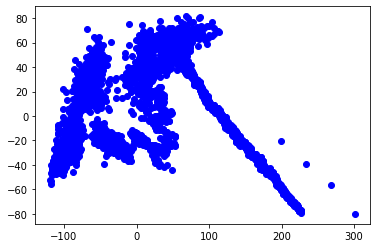

In [15]:
import matplotlib.pyplot as plt

plt.plot(X_reduced[:, 0], X_reduced[:, 1], 'bo')
plt.show()

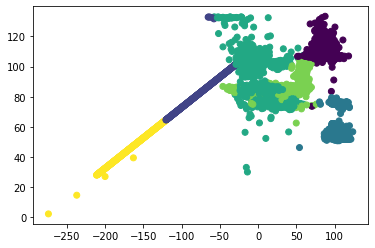

In [51]:
from sklearn.cluster import KMeans

k_labels = KMeans(n_clusters=6, random_state=0).fit_predict(awm)

plt.scatter(awm[:, 0], awm[:, 1], c=k_labels)
plt.show()

In [52]:
X_reduced.shape

(4505, 2)

In [53]:
k_labels.shape

(4505,)

In [54]:
import sys
np.set_printoptions(threshold=sys.maxsize)
print(k_labels)

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 

In [55]:
print(k_labels[0:900])

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 

In [56]:
print(k_labels[901:1800])

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 

In [57]:
print(k_labels[1801:2700])

[2 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 

In [58]:
print(k_labels[2701:3600])

[3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [59]:
print(k_labels[3601:4505])

[2 2 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [11]:
from keras import losses
from keras.metrics import categorical_accuracy
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Flatten, Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, GlobalAveragePooling2D, Dropout, GaussianNoise
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import SGD, Adam, Adadelta, Nadam
from keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.models import load_model as klm

In [12]:
input_vec = Input(shape=(7,))

#encoded = Dense(4, activation='relu')(input_vec)
encoded = Dense(2, activation='relu')(input_vec)

#decoded = Dense(4, activation='relu')(encoded)
decoded = Dense(7, activation='sigmoid')(encoded)

INFO:plaidml:Opening device "metal_amd_radeon_pro_560.0"


In [13]:
autoencoder = Model(input_vec, decoded)
autoencoder.compile(optimizer=Adam(lr=0.00005), loss='mse')

autoencoder.fit(awm, awm,
                epochs=1000,
                batch_size=8,
                shuffle=True,
                validation_split=0.8)

Train on 900 samples, validate on 3605 samples
Epoch 1/1000
900/900 [==============================] - 2s 2ms/step - loss: 2595.1760 - val_loss: 5238.8050
Epoch 2/1000
900/900 [==============================] - 1s 2ms/step - loss: 2595.0070 - val_loss: 5238.7722
Epoch 3/1000
900/900 [==============================] - 1s 1ms/step - loss: 2594.8264 - val_loss: 5238.7499
Epoch 4/1000
900/900 [==============================] - 1s 2ms/step - loss: 2594.6465 - val_loss: 5238.6853
Epoch 5/1000
900/900 [==============================] - 1s 2ms/step - loss: 2594.4415 - val_loss: 5238.6688
Epoch 6/1000
900/900 [==============================] - 1s 1ms/step - loss: 2594.2324 - val_loss: 5238.6100
Epoch 7/1000
900/900 [==============================] - 1s 2ms/step - loss: 2594.0309 - val_loss: 5238.5614
Epoch 8/1000
900/900 [==============================] - 1s 2ms/step - loss: 2593.8227 - val_loss: 5238.5138
Epoch 9/1000
900/900 [==============================] - 2s 2ms/step - loss: 2593.6125 - v

Epoch 76/1000
900/900 [==============================] - 1s 1ms/step - loss: 2565.9545 - val_loss: 5207.9519
Epoch 77/1000
900/900 [==============================] - 1s 1ms/step - loss: 2565.4043 - val_loss: 5208.4531
Epoch 78/1000
900/900 [==============================] - 1s 1ms/step - loss: 2564.8880 - val_loss: 5209.0278
Epoch 79/1000
900/900 [==============================] - 1s 1ms/step - loss: 2564.4599 - val_loss: 5209.6129
Epoch 80/1000
900/900 [==============================] - 1s 1ms/step - loss: 2564.1759 - val_loss: 5210.2845
Epoch 81/1000
900/900 [==============================] - 1s 1ms/step - loss: 2563.8945 - val_loss: 5210.9226
Epoch 82/1000
900/900 [==============================] - 1s 1ms/step - loss: 2563.5307 - val_loss: 5211.7092
Epoch 83/1000
900/900 [==============================] - 1s 1ms/step - loss: 2563.1734 - val_loss: 5212.2803
Epoch 84/1000
900/900 [==============================] - 1s 1ms/step - loss: 2562.9168 - val_loss: 5212.9632
Epoch 85/1000
900/9

900/900 [==============================] - 1s 1ms/step - loss: 2558.9855 - val_loss: 5216.2019
Epoch 151/1000
900/900 [==============================] - 1s 1ms/step - loss: 2558.9793 - val_loss: 5216.1667
Epoch 152/1000
900/900 [==============================] - 1s 1ms/step - loss: 2558.9714 - val_loss: 5216.1132
Epoch 153/1000
900/900 [==============================] - 1s 1ms/step - loss: 2558.9576 - val_loss: 5216.0706
Epoch 154/1000
900/900 [==============================] - 1s 1ms/step - loss: 2558.9475 - val_loss: 5216.0370
Epoch 155/1000
900/900 [==============================] - 1s 1ms/step - loss: 2558.9391 - val_loss: 5216.0100
Epoch 156/1000
900/900 [==============================] - 1s 1ms/step - loss: 2558.9325 - val_loss: 5215.9796
Epoch 157/1000
900/900 [==============================] - 1s 1ms/step - loss: 2558.9272 - val_loss: 5215.9527
Epoch 158/1000
900/900 [==============================] - 1s 1ms/step - loss: 2558.9226 - val_loss: 5215.9358
Epoch 159/1000
900/900 [=

900/900 [==============================] - 1s 1ms/step - loss: 2558.8744 - val_loss: 5214.7319
Epoch 225/1000
900/900 [==============================] - 1s 1ms/step - loss: 2558.8743 - val_loss: 5214.6947
Epoch 226/1000
900/900 [==============================] - 1s 1ms/step - loss: 2558.8743 - val_loss: 5214.6727
Epoch 227/1000
900/900 [==============================] - 1s 1ms/step - loss: 2558.8742 - val_loss: 5214.6318
Epoch 228/1000
900/900 [==============================] - 1s 2ms/step - loss: 2558.8741 - val_loss: 5214.6077
Epoch 229/1000
900/900 [==============================] - 1s 1ms/step - loss: 2558.8741 - val_loss: 5214.5758
Epoch 230/1000
900/900 [==============================] - 1s 1ms/step - loss: 2558.8740 - val_loss: 5214.5480
Epoch 231/1000
900/900 [==============================] - 1s 1ms/step - loss: 2558.8739 - val_loss: 5214.5143
Epoch 232/1000
900/900 [==============================] - 1s 1ms/step - loss: 2558.8739 - val_loss: 5214.4895
Epoch 233/1000
900/900 [=

900/900 [==============================] - 1s 1ms/step - loss: 2558.8721 - val_loss: 5213.5695
Epoch 299/1000
900/900 [==============================] - 1s 2ms/step - loss: 2558.8720 - val_loss: 5213.5702
Epoch 300/1000
900/900 [==============================] - 1s 2ms/step - loss: 2558.8720 - val_loss: 5213.5579
Epoch 301/1000
900/900 [==============================] - 1s 1ms/step - loss: 2558.8720 - val_loss: 5213.5556
Epoch 302/1000
900/900 [==============================] - 1s 2ms/step - loss: 2558.8720 - val_loss: 5213.5442
Epoch 303/1000
900/900 [==============================] - 1s 2ms/step - loss: 2558.8720 - val_loss: 5213.5403
Epoch 304/1000
900/900 [==============================] - 2s 2ms/step - loss: 2558.8719 - val_loss: 5213.5286
Epoch 305/1000
900/900 [==============================] - 1s 2ms/step - loss: 2558.8719 - val_loss: 5213.5261
Epoch 306/1000
900/900 [==============================] - 1s 2ms/step - loss: 2558.8719 - val_loss: 5213.5140
Epoch 307/1000
900/900 [=

KeyboardInterrupt: 

In [14]:
model = Model(input_vec, encoded)

In [16]:
ae_x = model.predict(awm)

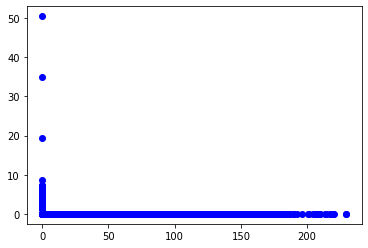

In [17]:
plt.plot(ae_x[:, 0], ae_x[:, 1], 'bo')
plt.show()